Please refer to https://github.com/Bryanbu2014/seminar-ki-gan-demo for guidelines on how to use this notebook

# Mount Google Drive

Connect to Google Drive to save models, generated images, and progress

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Data Preparation

Download and unzip the dataset, in this demonstration we will be using the CelebA dataset suggested by the book

In [ ]:
import os
from zipfile import ZipFile
from tqdm import tqdm

!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip

zip_path = 'celeba_gan/data.zip'
extract_to = 'celeba_gan/'

# Unzip
with ZipFile(zip_path, 'r') as zip_ref:
    file_names = zip_ref.namelist()
    with tqdm(total=len(file_names), desc="Extracting files") as progress_bar:
        for file in file_names:
            zip_ref.extract(member=file, path=extract_to)
            progress_bar.update(1)

Display one sample image

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

# Dataset directory
image_directory = os.path.join(extract_to, 'img_align_celeba')
image_files = os.listdir(image_directory)

# Select a random image file
random_image_file = random.choice(image_files)

# Load and display the random image
sample_image_path = os.path.join(image_directory, random_image_file)
print("Random image path:", sample_image_path)
image = Image.open(sample_image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

Create a dataset using Keras high level API from the unzipped directory

In [ ]:
# https://keras.io/api/data_loading/image/

image_resolution = 64

from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(image_resolution, image_resolution),
    batch_size=32,
    smart_resize=True)

In [ ]:
# Shape of the batch in the dataset

for batch in dataset:
    shape = batch.shape
    print(shape)
    print(f"Batch size: {shape[0]}")
    print(f"Image size (height, width): {shape[1]}, {shape[2]}")
    print(f"Channels: {shape[3]}")
    break

Now we normalize the pixel values of the images in the dataset, as it is a crucial preprocessing step in ML and DL pipelines

In [ ]:
import tensorflow as tf

# Normalization process involves scaling the pixel intensity values, which are
# originally in the range [0, 255]
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 255.0)

Display one processed image

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# Generative Adversarial Network (GAN)

GANs consist of two neural networks, the generator and the discriminator, both are trained simultaneously through an adversarial process

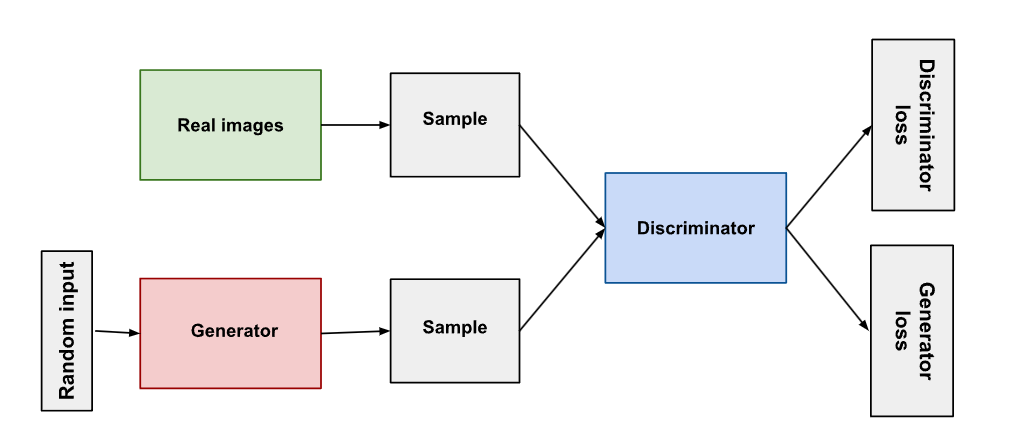

### The Generator Network

The generator's job is to create fake data that is as close as possible to the real data

In [ ]:
latent_dim = 128

generator = keras.Sequential(name="generator")

# Input layer
generator.add(keras.layers.Input(shape=(latent_dim,)))

# Dense layer
generator.add(keras.layers.Dense(8 * 8 * 128))

# Reshape layer
generator.add(keras.layers.Reshape((8, 8, 128)))

# Deconvolutional layers
generator.add(keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))
generator.add(keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))
generator.add(keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

# Convolutional layer
generator.add(keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"))

generator.summary()

ReLU vs LeakyReLU

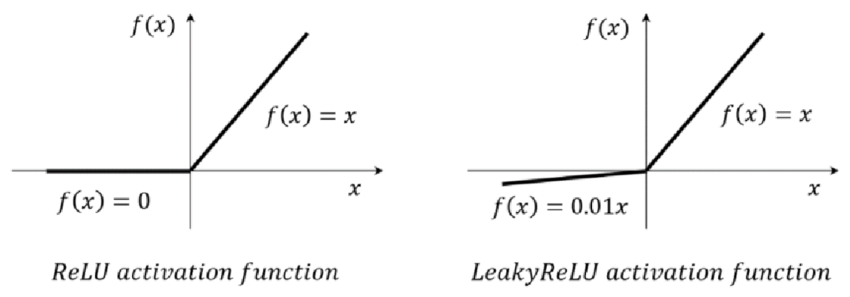

### The Discriminator Network

The discriminator's job is to classify data as either real (from the training dataset) or fake (produced by the generator)

In [ ]:
from tensorflow import keras

discriminator = keras.Sequential(name="discriminator")

# Input layer
discriminator.add(keras.Input(shape=(64, 64, 3)))

# Convolutional layers
discriminator.add(keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))

# Flatten layer
discriminator.add(keras.layers.Flatten())

# Dropout layer
discriminator.add(keras.layers.Dropout(0.2))

# Dense layer
discriminator.add(keras.layers.Dense(1, activation="sigmoid"))

# Summary of the model / neural network
discriminator.summary()

### The GAN Model

This section combines both generator and discriminator network to build a GAN model

In [ ]:
import tensorflow as tf

@keras.saving.register_keras_serializable()
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()  # Calls the compile method of the superclass (keras.Model) of GAN.
        # This is necessary to ensure that the model is set up correctly with any basic configurations handled by Keras's own Model class
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # Step-by-step training for both networks
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

    def get_config(self):
        config = super(GAN, self).get_config()
        # Storing the configuration of both sub-models
        config.update({
            "discriminator_config": self.discriminator.get_config(),
            "generator_config": self.generator.get_config(),
            "latent_dim": self.latent_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        discriminator = keras.Sequential.from_config(config["discriminator_config"])
        generator = keras.Sequential.from_config(config["generator_config"])
        latent_dim = config["latent_dim"]
        return cls(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

### Image Generation Callback

In [ ]:
# https://github.com/keras-team/keras/blob/v3.3.3/keras/src/callbacks/callback.py#L5

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    # Override on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 255).numpy()

      # Create a directory for every epoch
        epoch_dir = f"/content/drive/MyDrive/colab-notebooks/generative-adversarial-network/epoch-image/{epoch+1:03d}"
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img_path = os.path.join(epoch_dir, f"generated_img_{epoch+1:03d}_{i}.png")
            img.save(img_path)
            print(f"saving image to {img_path}")

# Model Training

### From Start

In [ ]:
# https://keras.io/api/optimizers/adam/

from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 100

checkpoint_filepath = "/content/drive/MyDrive/colab-notebooks/generative-adversarial-network/model-checkpoint/model_{epoch:02d}.keras"

# Save model
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1
)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)


gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy(),
            )

gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), model_checkpoint_callback])

### From Saved Model

In [ ]:
import re

model_name = os.listdir("/content/drive/MyDrive/colab-notebooks/generative-adversarial-network/model-checkpoint")
model_name_sorted = sorted(model_name, key=lambda x: int(x.split('_')[1].split('.')[0]))

match = re.search(r'\d{1,2}', model_name_sorted[-1])
if match:
    number = match.group()
    if len(number) == 2 and number[0] == '0':
        model_epoch = int(number[1])
    else:
        model_epoch = int(number)
print(f"model_name: {model_name_sorted[-1]}")
print(f"model_epoch: {model_epoch}")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_filepath = "/content/drive/MyDrive/colab-notebooks/generative-adversarial-network/model-checkpoint/model_{epoch:02d}.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1
)

model_name = os.listdir("/content/drive/MyDrive/colab-notebooks/generative-adversarial-network/model-checkpoint")[-1]
model_path = f"/content/drive/MyDrive/colab-notebooks/generative-adversarial-network/model-checkpoint/{model_name}"
gan = load_model(model_path, custom_objects={"GAN": GAN})

epochs = 100

gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy(),
            )
# initial_epoch indicates training up to and including the number of epoch
# initial_epoch=1 means training up to and including 1, so keras should start from the second epoch
gan.fit(dataset, epochs=epochs, initial_epoch=model_epoch, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), model_checkpoint_callback])

# Model Inference

In [ ]:
from tensorflow.keras.models import load_model

model_number = "101"

model_name = f"model_{model_number}.keras"
model_path = f"/content/drive/MyDrive/colab-notebooks/generative-adversarial-network/model-checkpoint/{model_name}"
model = load_model(model_path)

model.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss_fn=keras.losses.BinaryCrossentropy(),
              )

In [ ]:
import matplotlib.pyplot as plt

def model_inference(model, latent_dim=model.latent_dim, num_img=5):
    random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model.generator(random_latent_vectors)
    generated_images = (generated_images * 255).numpy()

    for i in range(num_img):
        img = keras.utils.array_to_img(generated_images[i])
        plt.imshow(img)
        plt.axis("off")
        plt.show()

In [ ]:
model_inference(model)

# Loss Graph

Training loss for both generator and discriminator from epoch 36 to 100

In [ ]:
# https://matplotlib.org/stable/

import matplotlib.pyplot as plt

epochs = list(range(36, 101))
d_loss = [0.6439, 0.6476, 0.6403, 0.6389, 0.6378, 0.6373, 0.6376, 0.6323, 0.6374,
          0.6382, 0.6331, 0.6378, 0.6355, 0.6319, 0.6295, 0.6300, 0.6296, 0.6278,
          0.6286, 0.6275, 0.6265, 0.6265, 0.6253, 0.6243, 0.6235, 0.6231, 0.6218,
          0.6194, 0.6184, 0.6177, 0.6166, 0.6148, 0.6152, 0.6116, 0.6116, 0.6074,
          0.6046, 0.6061, 0.6032, 0.6017, 0.6018, 0.5988, 0.5978, 0.5954, 0.5960,
          0.5928, 0.5929, 0.5886, 0.5877, 0.5869, 0.5841, 0.5804, 0.5804,   0.5771,
          0.5771, 0.5733, 0.5712, 0.5701, 0.5676, 0.5655, 0.5646, 0.5640, 0.5600,
          0.5589, 0.5561]
g_loss = [0.9513, 0.9552, 0.9612, 0.9628, 0.9722, 0.9694, 0.9768, 0.9734, 0.9750,
          0.9747, 0.9730, 0.9737, 0.9918, 0.9947, 0.9935, 0.9826, 0.9956, 0.9946,
          0.9888, 1.0048, 0.9887, 1.0034, 1.0036, 1.0060, 1.0110, 1.0081, 0.9988,
          1.0181, 1.0205, 1.0234, 1.0180, 1.0300, 1.0378, 1.0360, 1.0462, 1.0429,
          1.0506, 1.0523, 1.0589, 1.0581, 1.0616, 1.0747, 1.0667, 1.0763, 1.0750,
          1.0862, 1.0859, 1.0969, 1.1003, 1.1096, 1.1134, 1.1180, 1.1319, 1.1462,
          1.1330, 1.1494, 1.1587, 1.1617, 1.1622, 1.1747, 1.1796, 1.1784, 1.1972,
          1.2023, 1.2050]

plt.figure(figsize=(10, 5))
plt.plot(epochs, g_loss, label='g_loss (generator)', marker='x')
plt.plot(epochs, d_loss, label='d_loss (discriminator)', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend(loc='center')
plt.grid(True)
plt.show()